<h1><center>Natural-looking digit generation</center></h1>

![palette of the 10 digits](imgs/digitpalette.png)

You can read about this notebook in [my blog](https://mathspp.blogspot.com)

## Required setup

Imports, loading the data, etc

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])#,
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    print(np.transpose(npimg, (1,2,0)).shape)
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

(32, 122, 3)


<Figure size 640x480 with 1 Axes>

    0     1     4     8


# Encoder

The neural network that is used to encode the images and used to train the decoder

In [4]:
import torch.nn as nn
import torch.nn.functional as F

use_gpu = torch.cuda.is_available()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(28*28, 600)
        self.linear2 = nn.Linear(600, 350)
        self.linear3 = nn.Linear(350, 100)
        self.linear4 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
"""

net = Net()

if use_gpu:
    net = net.cuda()

In [5]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Either train your network or load it from a file

### Train

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = torch.reshape(inputs, (4, 28*28))
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
            niter = epoch * len(trainloader) + i

[1,   100] loss: 2.304
[1,   200] loss: 2.293
[1,   300] loss: 2.284
[1,   400] loss: 2.274
[1,   500] loss: 2.255
[1,   600] loss: 2.222
[1,   700] loss: 2.188
[1,   800] loss: 2.124
[1,   900] loss: 2.011
[1,  1000] loss: 1.772
[1,  1100] loss: 1.532
[1,  1200] loss: 1.310
[1,  1300] loss: 1.080
[1,  1400] loss: 0.960
[1,  1500] loss: 0.803
[1,  1600] loss: 0.863
[1,  1700] loss: 0.662
[1,  1800] loss: 0.738
[1,  1900] loss: 0.720
[1,  2000] loss: 0.657
[1,  2100] loss: 0.600
[1,  2200] loss: 0.524
[1,  2300] loss: 0.600
[1,  2400] loss: 0.541
[1,  2500] loss: 0.599
[1,  2600] loss: 0.594
[1,  2700] loss: 0.481
[1,  2800] loss: 0.510
[1,  2900] loss: 0.499
[1,  3000] loss: 0.467
[1,  3100] loss: 0.489
[1,  3200] loss: 0.431
[1,  3300] loss: 0.394
[1,  3400] loss: 0.385
[1,  3500] loss: 0.442
[1,  3600] loss: 0.424
[1,  3700] loss: 0.341
[1,  3800] loss: 0.387
[1,  3900] loss: 0.405
[1,  4000] loss: 0.364
[1,  4100] loss: 0.373
[1,  4200] loss: 0.294
[1,  4300] loss: 0.421
[1,  4400] 

### Load

In [6]:
net = Net()
net.load_state_dict(torch.load("models/encoder_v0.pt"))
net.eval()

Net(
  (linear1): Linear(in_features=784, out_features=600, bias=True)
  (linear2): Linear(in_features=600, out_features=350, bias=True)
  (linear3): Linear(in_features=350, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=10, bias=True)
)

### Check accuracy of the trained encoder

In [7]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = torch.reshape(images, (4, 28*28))
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 96 %


# Decoder

In [9]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(10, 100)
        self.linear2 = nn.Linear(100, 350)
        self.linear3 = nn.Linear(350, 600)
        self.linear4 = nn.Linear(600, 28*28)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x
    

decoder = Decoder()

if use_gpu:
    decoder = decoder.cuda()
    
decCriterion = nn.MSELoss()
decOptimizer = optim.SGD(decoder.parameters(), lr=0.001, momentum=0.9)

## Either train the decoder or load it

### Train

In [39]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = torch.reshape(inputs, (4, 28*28))
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        outputs = net(inputs)
        
        decOptimizer.zero_grad()
        # forward + backward + optimize
        decOutputs = decoder(outputs)
        loss = decCriterion(decOutputs, inputs)
        loss.backward()
        decOptimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
            niter = epoch * len(trainloader) + i

[1,   100] loss: 0.135
[1,   200] loss: 0.116
[1,   300] loss: 0.109
[1,   400] loss: 0.101
[1,   500] loss: 0.100
[1,   600] loss: 0.093
[1,   700] loss: 0.087
[1,   800] loss: 0.086
[1,   900] loss: 0.083
[1,  1000] loss: 0.078
[1,  1100] loss: 0.077
[1,  1200] loss: 0.076
[1,  1300] loss: 0.075
[1,  1400] loss: 0.070
[1,  1500] loss: 0.072
[1,  1600] loss: 0.070
[1,  1700] loss: 0.069
[1,  1800] loss: 0.072
[1,  1900] loss: 0.070
[1,  2000] loss: 0.070
[1,  2100] loss: 0.068
[1,  2200] loss: 0.068
[1,  2300] loss: 0.067
[1,  2400] loss: 0.067
[1,  2500] loss: 0.068
[1,  2600] loss: 0.066
[1,  2700] loss: 0.067
[1,  2800] loss: 0.065
[1,  2900] loss: 0.067
[1,  3000] loss: 0.064
[1,  3100] loss: 0.065
[1,  3200] loss: 0.065
[1,  3300] loss: 0.067
[1,  3400] loss: 0.064
[1,  3500] loss: 0.064
[1,  3600] loss: 0.064
[1,  3700] loss: 0.064
[1,  3800] loss: 0.064
[1,  3900] loss: 0.063
[1,  4000] loss: 0.062
[1,  4100] loss: 0.063
[1,  4200] loss: 0.064
[1,  4300] loss: 0.064
[1,  4400] 

### Load

In [10]:
decoder = Decoder()
decoder.load_state_dict(torch.load("models/decoder_v0.pt"))
decoder.eval()

Decoder(
  (linear1): Linear(in_features=10, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=350, bias=True)
  (linear3): Linear(in_features=350, out_features=600, bias=True)
  (linear4): Linear(in_features=600, out_features=784, bias=True)
)

### Check how one image looks like after being encoded and decoded

tensor([[-3.2723,  3.7296,  9.6557,  4.9145, -8.6327, -3.1320, -3.5934,  6.0783,
         -0.8307, -5.3434]], grad_fn=<AddmmBackward>)


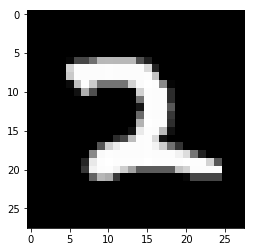

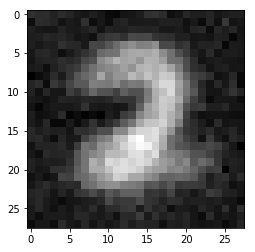

In [11]:
# take some image
imgs, lbls = iter(trainloader).next()
img = imgs[0]
digit = lbls[0]

out = net(torch.reshape(img, (1, 28*28)))
print(out)
out2 = decoder(out)

npimg1 = img.numpy().reshape((28, 28))
plt.imshow(npimg1, cmap="gray")
plt.show()

npimg2 = out2.detach().numpy().reshape((28,28))
plt.imshow(npimg2, cmap="gray")
plt.show()

# Natural-looking digit generation

In [20]:
import random

def fake_vector(n):
    """This function should mimic, in some sense,
    the output of net(img) if <img> were the digit <n>"""
    hit = 13 + random.random()
    others = [3*random.random()-2 for i in range(10)]
    others[n] = hit
    return others

### Plot some images for each digit

The images may look like the same, but they are actually different.

As of now, all the digits have a blurry look and the 2, the 7 and the 9 are the ones that look worse.

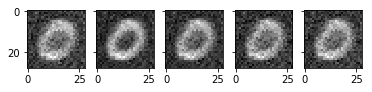

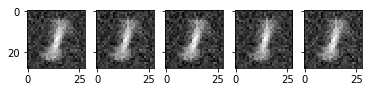

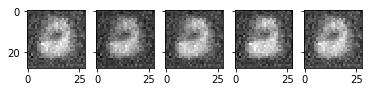

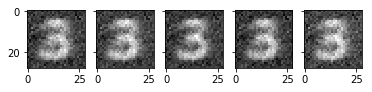

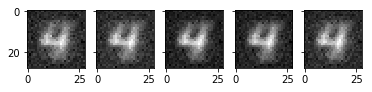

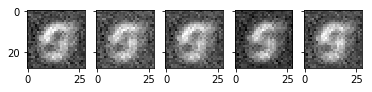

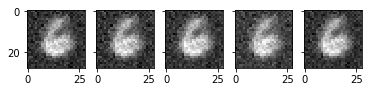

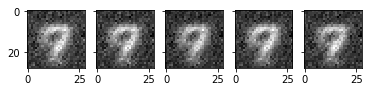

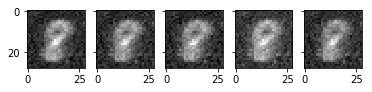

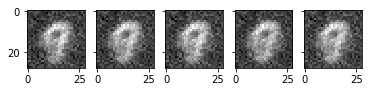

In [24]:
digits = []
for d in range(10):
    f, plots = plt.subplots(1, 5, sharey=True)
    this_digit_list = []
    for i in range(5):
        testingInput = torch.tensor(fake_vector(d))
        out = decoder(testingInput)
        out = torch.reshape(out, [28, 28])

        nparray = out.detach().numpy()
        nparray = nparray - np.min(nparray)
        nparray = nparray/np.max(nparray)

        this_digit_list.append(nparray)
        plots[i].imshow(nparray, cmap="gray")
    digits.append(this_digit_list)
    plt.savefig(f"imgs/generated_{d}.png")
    plt.show()

### Try to enhance the images

By using some thresholding, perhaps the blurring can be gone

In [34]:
# For the results below to match what is already displayed, the "digits" list should be
# the same as when I ran this, so evaluating this cell overrides the "digits" variable with 
# the contents I used, loading it
###np.save("digits.npy", digits)
digits = np.load("digits.npy")

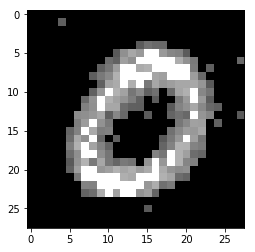

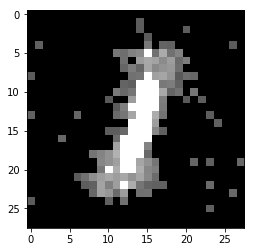

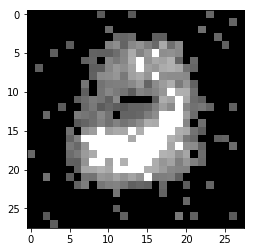

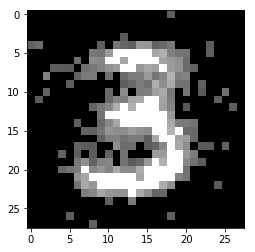

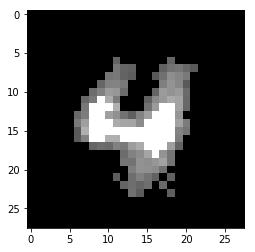

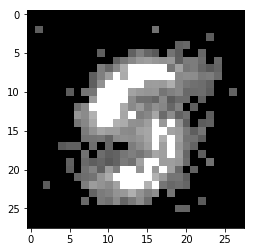

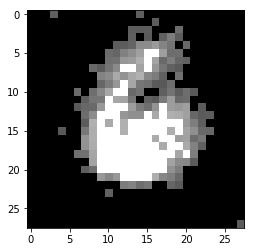

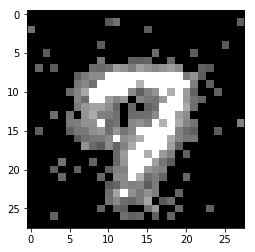

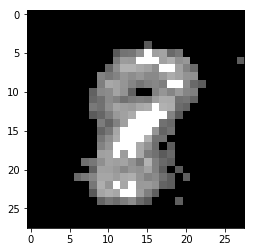

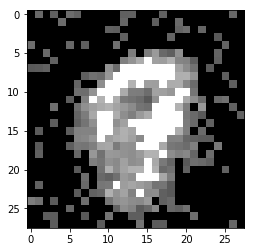

In [36]:
# picked by hand, the indices of the best looking digit
best = [1, 2, 1, 2, 2, 3, 4, 1, 0, 2]

for d in range(10):
    digit = digits[d][best[d]]
    # normalize the image
    digit = digit - np.min(digit)
    digit = digit/np.max(digit)
    digit[digit < 0.35] = 0
    digit[digit > 0.7] = 1
    plt.imshow(digit, cmap="gray")
    plt.savefig(f"imgs/single_digit_{d}.png")
    plt.show()

## Save the two trained networks for later, so that they can be imported as well

In [44]:
torch.save(net.state_dict(), "models/encoder_v0.pt")
torch.save(decoder.state_dict(), "models/decoder_v0.pt")

## Loading the two networks

In [45]:
net = Net()
net.load_state_dict(torch.load("models/encoder_v0.pt"))
net.eval()
decoder = Decoder()
decoder.load_state_dict(torch.load("models/decoder_v0.pt"))
decoder.eval()

Decoder(
  (linear1): Linear(in_features=10, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=350, bias=True)
  (linear3): Linear(in_features=350, out_features=600, bias=True)
  (linear4): Linear(in_features=600, out_features=784, bias=True)
)